In [2]:
import json
import boto3
import collections
import pandas as pd


CONTRACT_TABLE = 'opensea-contracts-valid'
S3_BUCKET = 'metastitch-ml-assets'

dynamo_client = boto3.client('dynamodb',region_name="us-west-2")
dynamoDB = boto3.resource('dynamodb',region_name="us-west-2")

s3_client = boto3.client('s3')

# Scan Table and Convert to CSV

In [3]:
table = dynamoDB.Table(CONTRACT_TABLE)

response = table.scan()
data = response['Items']

while 'LastEvaluatedKey' in response:
    response = table.scan(ExclusiveStartKey=response['LastEvaluatedKey'])
    data.extend(response['Items'])

In [64]:
data[:5]

[{'processed': Decimal('1675934378'),
  'media_urls': ['https://etherscan.io/address/0x4baf72c20f7a345f62d5795ad4fd80bba42a2f50',
   'https://lilbubble.wtf',
   'https://discord.gg/xKQHV7X6A7',
   'https://www.instagram.com/thecryptobubble',
   'https://www.twitter.com/TheCryptoBubble',
   'https://www.twitter.com/thecryptobubble',
   'https://www.youtube.com/thecryptobubble',
   'https://www.discord.gg/xKQHV7X6A7'],
  'collection_url': 'https://opensea.io/collection/lil-bubble-collectibles',
  'block_timestamp': Decimal('1629889546'),
  'volume': '28',
  'desc': '[twitter](https://www.twitter.com/thecryptobubble) | [youtube](https://www.youtube.com/thecryptobubble) | [discord](https://www.discord.gg/xKQHV7X6A7)  \nOfficial collectibles of the singing spaceman, Lil Bubble 👨\u200d🚀  \nThis collection is for my NFT experiments and will be added to over time.  \nOther official Lil Bubble collections: [Parody Pix](https://opensea.io/collection/parody-pix)',
  'thumbnail_urls': ['https://i.

In [4]:
contract_address = []
desc = []
thumbnail_url = []
volume = []
results = collections.defaultdict(list)
keys = ['contract_address', 'desc', 'thumbnail_urls', 'volume']
for contract in data:
    for key in keys:
        results[key].append(contract[key])

In [5]:
contract_df = pd.DataFrame(data = results)

In [6]:
# Remove Contract with No Description
contract_df = contract_df.dropna()
contract_df = contract_df[contract_df['desc']!='']

# Sort by Volume, get the top 50000
contract_df['volume'] = contract_df['volume'].str.replace('<', '').astype('float64')
contract_df = contract_df.sort_values(by='volume', ascending=False)
contract_df = contract_df[:50000]

In [7]:
contract_df = contract_df.reset_index(drop=True)
contract_df.head()

,contract_address,desc,thumbnail_urls,volume
0,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,The Bored Ape Yacht Club is a collection of 10...,[https://i.seadn.io/gae/X7pJZ1LhxEVQpj6OSpnYNy...,825422.0
1,0x60e4d786628fea6478f785a6d7e704777c86a7c6,The MUTANT APE YACHT CLUB is a collection of u...,[https://i.seadn.io/gae/xJoW89orPjqLBAxY53Ryxu...,590318.0
2,0xed5af388653567af2f388e6224dc7c4b3241c544,Take the red bean to join the garden. View the...,[https://i.seadn.io/gcs/files/cff9904bc0cb118f...,352307.0
3,0x49cf6f5d44e70224e2e23fdcdd2c053f30ada28b,"🧬 CLONE X 🧬\r\n\r\n20,000 next-gen Avatars, by...",[https://i.seadn.io/gcs/files/0439ebd2c631a282...,298686.0
4,0x23581767a106ae21c074b2276d25e5c3e136a68b,"A collection of 10,000 PFPs which grant their ...",[https://openseauserdata.com/files/0fe7e60b9a9...,212939.0


## Clean Description (Text Input)

In [8]:
import re


def cleaner(text):
    text = text.lower()
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    text = text.replace('\r\n', ' ').replace('\n', ' ')
    return text

In [9]:
contract_df['desc'] = contract_df['desc'].apply(cleaner)

In [10]:
contract_df.head()

,contract_address,desc,thumbnail_urls,volume
0,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,the bored ape yacht club is a collection of 10...,[https://i.seadn.io/gae/X7pJZ1LhxEVQpj6OSpnYNy...,825422.0
1,0x60e4d786628fea6478f785a6d7e704777c86a7c6,the mutant ape yacht club is a collection of u...,[https://i.seadn.io/gae/xJoW89orPjqLBAxY53Ryxu...,590318.0
2,0xed5af388653567af2f388e6224dc7c4b3241c544,take the red bean to join the garden view the ...,[https://i.seadn.io/gcs/files/cff9904bc0cb118f...,352307.0
3,0x49cf6f5d44e70224e2e23fdcdd2c053f30ada28b,clone x 20000 nextgen avatars by rtfkt and ta...,[https://i.seadn.io/gcs/files/0439ebd2c631a282...,298686.0
4,0x23581767a106ae21c074b2276d25e5c3e136a68b,a collection of 10000 pfps which grant their h...,[https://openseauserdata.com/files/0fe7e60b9a9...,212939.0


In [13]:
# Export to s3
FILE_NAME  = 'top50000contract.csv'
contract_df.to_csv(FILE_NAME, index=False)
TO_DUMP = 'data_for_clip/' + FILE_NAME
s3_client.upload_file(FILE_NAME, S3_BUCKET, TO_DUMP)

## Download Thumbnail, Preprocess by CLIP and Dump to Disk

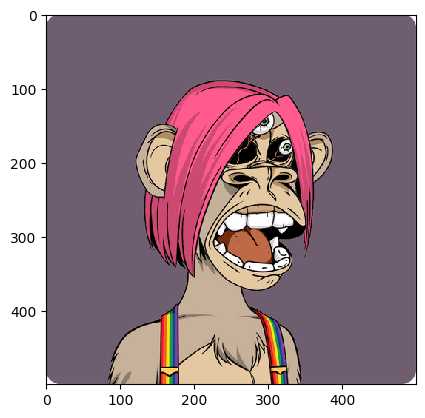

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
# Read Images
img = mpimg.imread('test.png')
 
# Output Images
plt.imshow(img)

In [35]:
!pip install git+https://github.com/openai/CLIP.git
!pip install torch

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-wmis1lr2
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-wmis1lr2
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=9510e6dd683a95baba2db94c7a7a2bf39af419ff5748316aa738789a1a1196e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-hf0vv54v/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [13]:
import requests
import os
import clip 
import torch
from PIL import Image
import io
_, preprocess = clip.load("ViT-B/32") 

def download_imgs(idxes, contract_df, saved_folder, timeout):
    for i in idxes:
        contract_address = contract_df.loc[i, 'contract_address']
        # Choose the fisrt url for convenience
        if len(contract_df.loc[i, 'thumbnail_urls'])>0:
            url = contract_df.loc[i, 'thumbnail_urls'][0]
            saved_path = os.path.join(saved_folder, contract_address)
            if not os.path.exists(saved_path):
                try:
                    r = requests.get(url, allow_redirects=True, timeout=timeout).content
                    image = Image.open(io.BytesIO(r))
                    post_image = preprocess(image)
                    # with open(saved_path, 'wb') as f:
                    #     f.write(r.content)
                    torch.save(post_image, saved_path)
                except Exception as e: 
                    print(e)


In [41]:
# Depreacted, switch to Queue implemention, and directly dump CLIP preprocessed features

# SAVED_FOLDER = 'thumbnail'
# TIMEOUT = 5

# idxes = []
# for i in range(0, len(contract_df), 1000):
#     idxes.append(list(range(i, i+1000)))
    
# threads = []
# for lst in idxes:
    
#     t = threading.Thread(target=download_imgs, args=(lst, contract_df, SAVED_FOLDER, TIMEOUT))
#     t.start()


# for thread in threads:
#     thread.join()

HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=5)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=5)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=5)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=5)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=5)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=5)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=5)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=5)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=5)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out.
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=5)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=5)
HTTPSConnectionPool(h

In [36]:
# Setting up the Queue

from queue import Queue
import logging
from threading import Thread
#set up the queue to hold all the urls
q = Queue(maxsize=0)

num_theads = 10
TIMEOUT = 3
SAVED_FOLDER = './vision_feature'

for i in range(len(contract_df)):
    if len(contract_df.loc[i, 'thumbnail_urls'])>0:
        url = contract_df.loc[i, 'thumbnail_urls'][0]
        contract_address = contract_df.loc[i, 'contract_address']
        q.put((contract_address,url))

def download_imgs(q):
    while not q.empty():
        contract_address, url = q.get()


        saved_path = os.path.join(SAVED_FOLDER, contract_address)
        if not os.path.exists(saved_path):
            try:
                r = requests.get(url, allow_redirects=True, timeout=TIMEOUT).content
                image = Image.open(io.BytesIO(r))
                post_image = preprocess(image)
                # with open(saved_path, 'wb') as f:
                #     f.write(r.content)
                torch.save(post_image, saved_path)
            except Exception as e: 
                print(e)
        q.task_done()
        




In [ ]:
#Starting worker threads on queue processing
for i in range(num_theads):
    logging.debug('Starting thread ', i)
    worker = Thread(target=download_imgs, args=(q,))
    worker.setDaemon(True)    #setting threads as "daemon" allows main program to 
                              #exit eventually even if these dont finish 
                              #correctly.
    worker.start()

#now we wait until the queue has been processed
q.join()

logging.info('All tasks completed.')

HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=3)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=3)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=3)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=3)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=3)


# Prepare Vision Text Pair to Json

In [56]:
from glob import glob
vision_feats = glob('./vision_feature/*')
valid_contracts = [item.split('/')[-1] for item in vision_feats]
contract_df = contract_df[contract_df['contract_address'].isin(valid_contracts)].reset_index(drop=True)

In [57]:
desc_full = {}
cleaned_vision_feats = []
null_contracts = []
# There are some with no description, remove them first

for i in range(len(contract_df)):
    
    contract = contract_df.loc[i, 'contract_address']
    
    d = contract_df.loc[i, 'desc']
    
    if type(d) == float or len(d)<10:
        null_contracts.append(contract)
        continue 
    img_file = os.path.join(SAVED_FOLDER, contract)
    desc_full[img_file] = d
    cleaned_vision_feats.append(img_file)

vision_feats = cleaned_vision_feats
    

In [65]:
import json

SPLIT_RATIO = 0.9

split_idx = int(len(desc_full)*SPLIT_RATIO)
train_json = dict(list(desc_full.items())[:split_idx])
test_json = dict(list(desc_full.items())[split_idx:])

DATA_FOLDER = './data'

with open(os.path.join(DATA_FOLDER, 'train_50000.json'), 'w') as f:
    json.dump(train_json, f)
    
with open(os.path.join(DATA_FOLDER, 'test_50000.json'), 'w') as f:
    json.dump(test_json, f)
    
    